In [20]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

import torch.nn as nn

# Create dataset

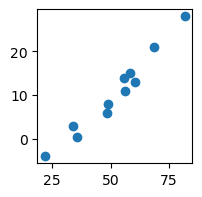

In [21]:
# Dataset for linear regression, y=wx+b
# Targets (y)
# .unsqueeze turns the 1D vector into a 2D single column tensor
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]).unsqueeze(1)
# Inputs (x)
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]).unsqueeze(1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2)) # Width 2 inches, height 2 inches
ax.scatter(t_u, t_c)

# Rescaling the input for better gradient computation
# Some optimizers are more sensitive to the scale of the data, e.g. the stochastic gradient descent
t_un = 0.1 * t_u

In [22]:
# Splitting the dataset
n_samples = t_u.shape[0]
print("Number of samples", n_samples)
n_val = int(0.2 * n_samples)
print("Validation set size", n_val)
# Shuffling the indices of the dataset. The result is a tensor
shuffled_indices = torch.randperm(n_samples)
# Indices of training and validating sets
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

# Training set
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
# Validation set
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

# Rescaled training set
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

Number of samples 11
Validation set size 2


In [23]:
# Define a neural network
seq_model = nn.Sequential(
            nn.Linear(1, 13),
            nn.Tanh(),
            nn.Linear(13, 1))
print(seq_model)

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)


In [24]:
# Show the shape of the parameters
# The first layer takes 1 input and gives 13 outputs
# Each output comes from a linear map like wx+b
# The second layer takes 13 inputs and gives 1 output
# The output comes from a linear map like w1 x1 + ... w13 x13 + b
for param in seq_model.parameters():
    print(param.shape)

torch.Size([13, 1])
torch.Size([13])
torch.Size([1, 13])
torch.Size([1])


In [25]:
# Show the names and shapes of the parameters
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [26]:
# Get individual layer
print( seq_model[0] )

Linear(in_features=1, out_features=13, bias=True)


In [27]:
# Training loop
def training_loop(n_epochs, optimizer, model, loss_fn, 
                  train_t_u, val_t_u, train_t_c, val_t_c):
    
    for epoch in range(1, n_epochs + 1):
        # Forward propagation (computing the loss)
        train_loss = loss_fn(model(train_t_u), train_t_c)
        val_loss = loss_fn(model(val_t_u), val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                    f" Validation loss {val_loss.item():.4f}")



# Number of epochs
n_epochs=10000
# Create an optimizer
# Note that the first argument of optim.SGD must be an iterable
# linear_model.parameters() creates a generator of the parameters
optimizer = optim.SGD(seq_model.parameters(), lr=1e-2)

# Use pytorch's mean square loss 
# loss_fn=nn.MSELoss() creates an object. We can use it as loss_fn(Predictions, Targets),
# just the same as our manually defined loss in the last chapter
loss_fn=nn.MSELoss()
training_loop(n_epochs, optimizer, seq_model, loss_fn, 
              train_t_un, val_t_un, train_t_c, val_t_c)

print("Prediction on the validation set", seq_model(val_t_un))
print("True validation set targets", val_t_c)

Epoch 1, Training loss 235.8648, Validation loss 116.4390
Epoch 2, Training loss 172.2986, Validation loss 61.7115
Epoch 3, Training loss 135.3139, Validation loss 32.0098
Epoch 1000, Training loss 7.7418, Validation loss 2.5659
Epoch 2000, Training loss 1.1621, Validation loss 3.1298
Epoch 3000, Training loss 1.0202, Validation loss 4.8915
Epoch 4000, Training loss 0.9237, Validation loss 4.7614
Epoch 5000, Training loss 0.8671, Validation loss 4.6745
Epoch 6000, Training loss 0.8280, Validation loss 4.6167
Epoch 7000, Training loss 0.7997, Validation loss 4.5801
Epoch 8000, Training loss 0.7783, Validation loss 4.5592
Epoch 9000, Training loss 0.7616, Validation loss 4.5489
Epoch 10000, Training loss 0.7481, Validation loss 4.5457
Prediction on the validation set tensor([[13.7855],
        [ 7.1146]], grad_fn=<AddmmBackward0>)
True validation set targets tensor([[11.],
        [ 8.]])


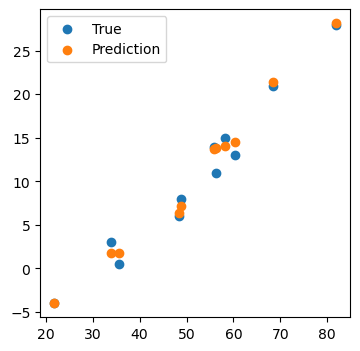

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4)) # Width 4 inches, height 4 inches
ax.scatter(t_u, t_c, label="True")
# To plot the prediction, we need to stop autograd, otherwise matplotlib will raise error
# .detach creates a new tensor that shares the same storage but without autograd
ax.scatter(t_u, seq_model(t_un).detach(), label="Prediction")
ax.legend()